In [51]:
import sys
sys.path.append('/Users/aimeebarciauskas/Library/Python/3.6/lib/python/site-packages')
sys.path.append('/Users/aimeebarciauskas/Projects/ifsc/')
import psycopg2
import helpers
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from scipy import stats

## What is the distribution of the previous heat for world cup winners?

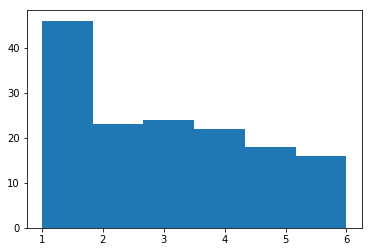

In [4]:
previous_heat_final = helpers.fetch_all(
    'previous_heat',
    'bouldering_comp_results',
    "comp_stage_rank = 1 and comp_stage = 'final'")
previous_heat_final = list(map(lambda row: row[0], previous_heat_final))

plt.hist(previous_heat_final, bins=6)
plt.show()

## What is the distribution of previous heat for first position semifinalists?

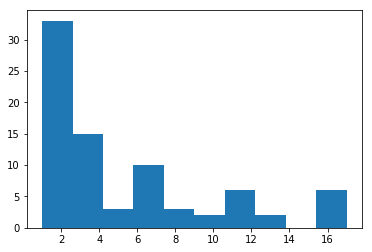

In [63]:
previous_heat_semifinal = helpers.fetch_all(
    'previous_heat',
    'bouldering_comp_results',
    "comp_stage_rank = 1 and comp_stage = 'semifinal' and previous_heat is not NULL")
previous_heat_semifinal = list(map(lambda row: row[0], previous_heat_semifinal))

plt.hist(previous_heat_semifinal)
plt.show()

## What is the distribution of attempts to tops?

Boulderers are far more likely to top boulders when the first attempt is a flash.

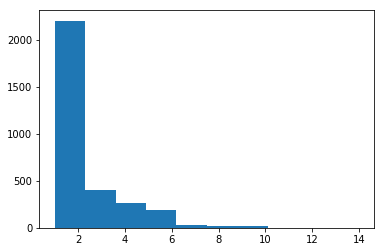

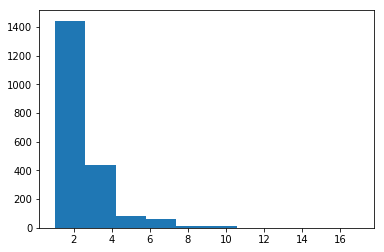

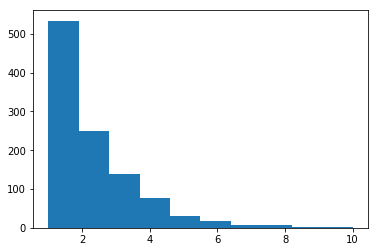

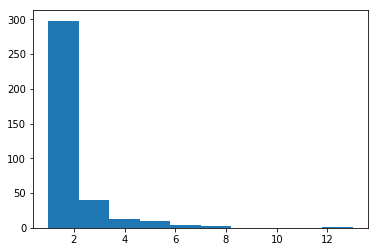

In [6]:
for attempts in range(1,5):
    boulder_top_tries = helpers.fetch_all(
        'boulder_{0}_top_tries'.format(attempts),
        'bouldering_comp_results',
        'boulder_{0}_top_tries is not NULL'.format(attempts)
    )
    boulder_top_tries = list(map(lambda row: row[0], boulder_top_tries))
    plt.hist(boulder_top_tries)
    plt.show()

Interesting, looks like there is evidence that probability of topping decreases in later boulders.

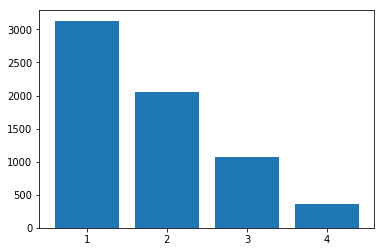

In [10]:
boulder_tops = {}
for attempts in range(1,5):
    boulder_x_tops = helpers.fetch_all(
        'count(*)',
        'bouldering_comp_results',
        'boulder_{0}_top_tries is not NULL'.format(attempts)
    )
    boulder_x_tops = list(map(lambda row: row[0], boulder_x_tops))
    boulder_tops[str(attempts)] = boulder_x_tops[0]


plt.bar(boulder_tops.keys(), boulder_tops.values())
plt.show()

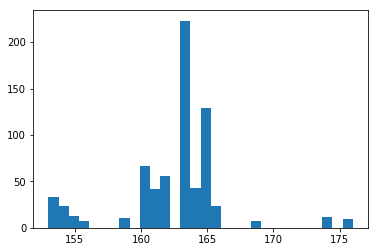

In [13]:
# Heights for all female boulderers
rows = helpers.fetch_all(
    'athletes.height',
    'bouldering_comp_results join athletes on athletes.id = bouldering_comp_results.athlete_id',
    "athletes.height is not NULL and bouldering_comp_results.category = 'womens_bouldering'")
all_wboulder_heights = list(map(lambda row: row[0], rows))

plt.hist(all_wboulder_heights, bins=30)
plt.show()

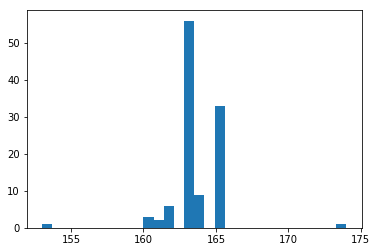

In [14]:
# Heights for female boulderers who finish first
rows = helpers.fetch_all(
    'athletes.height',
    'bouldering_comp_results join athletes on athletes.id = bouldering_comp_results.athlete_id',
    "athletes.height is not NULL and bouldering_comp_results.category = 'womens_bouldering' and bouldering_comp_results.comp_stage_rank = 1")
first_wboulder_heights = list(map(lambda row: row[0], rows))

plt.hist(first_wboulder_heights, bins=30)
plt.show()

In [18]:
mean_all = np.mean(all_wboulder_heights)
mean_firsts = np.mean(first_wboulder_heights)

print('Mean for all women is {0}'.format(mean_all))
print('Mean for women who come in first (both final and semifinal) is {0}'.format(mean_firsts))

Mean for all women is 162.42632331902718
Mean for women who come in first (both final and semifinal) is 163.51351351351352


Null hypothesis: The height of women coming in first place at IFSC bouldering world cups is the same as for all women boulderers.
Alternative hypothesis: The height of women coming in first place at IFSC bouldering world cups is higher than for all women entering the world cup.

In [136]:
# Reference: https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

def var(x):
    numpy_x = np.array(x)
    M = np.mean(numpy_x)
    numer = np.sum((numpy_x - M)**2)
    return numer / len(numpy_x)

def tstat(x, y, N):
    meanx, meany = np.mean(x), np.mean(y)
    varx, vary = var(x), var(y)
    numer = meanx - meany
    denom = np.sqrt((varx / N) + (vary / N))
    return numer / denom

def pvalue(tstat, N):
    df = 2*N - 2
    return 1 - stats.t.cdf(tstat, df = df)

N = 25
ntests = 10000
iter_idx = 0

pvalues = []

while iter_idx <= ntests:
    # Sample populations
    random_sample_all = np.random.choice(all_wboulder_heights, size=N)
    random_sample_firsts = np.random.choice(first_wboulder_heights, size=N)
    #tstat = tstat(random_sample_firsts, random_sample_all, N)
    #pvalue = pvalue(tstat, N)
    # Can sanity check above values with stats.ttest_ind
    t2, p2 = stats.ttest_ind(random_sample_firsts, random_sample_all, equal_var=False)
    pvalues.append(p2)
    iter_idx += 1

np.sum(np.array(pvalues) <= 0.05)/ntests

0.2435

Can only reject the null hypothesis that women's heights are different for first place finishers about in about 24% of tests.